In [1]:
import pickle
import pandas as pd
from collections import defaultdict
import numpy as np
import datetime
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

with open('user_songs_train.json', 'rb') as f:
    user_songs_train = pickle.load(f)
with open('user_songs_test.json', 'rb') as f:
    user_songs_test = pickle.load(f)
with open('ratings_train.json', 'rb') as f:
    ratings_train = pickle.load(f)
with open('ratings_test.json', 'rb') as f:
    ratings_test = pickle.load(f)
with open('song_users_train.json', 'rb') as f:
    song_users_train = pickle.load(f)
with open('song_users_test.json', 'rb') as f:
    song_users_test = pickle.load(f)
with open('ratings_train_s.json', 'rb') as f:
    ratings_train_s = pickle.load(f)
with open('ratings_test_s.json', 'rb') as f:
    ratings_test_s = pickle.load(f)

In [3]:
len(user_songs_train)

999

In [4]:
len(song_users_train)

2471

In [5]:
N, M = len(user_songs_train), len(song_users_train)

In [6]:
# K number of latent features
K = 10
W = np.random.rand(N,K)
b = np.zeros(N)
U = np.random.rand(M,K)
c = np.zeros(M)
mu = np.mean(list(ratings_train.values()))


In [7]:
U.shape

(2471, 10)

In [8]:
def get_loss(s2u):  
    '''s2u(key) is 'song_ID' and value is (list of users, np.array(ratings))
    we create vector of predictions in vectorized form'''
    Nr= 0
    sse = 0
    for j,(uid,r) in s2u.items():
        p = W[uid].dot(U[j])+b[uid]+c[j]+ mu
        error = p-r 
        sse += error.dot(error)
        Nr +=len(r)
    return sse/Nr

In [9]:
# convert user2song and song2user to include ratings
# if I have a list of songs I can adress U and c directly and I need a coresponding rating
# currently we have a single dictonary that takes only single song j and single user i and look for rating
# for each user I want to have all the songs and all corresponding ratings
# it is faster to loop across songs dict then across users dict since in the data set we have 
# more songs then users
print("converting...")
user_songs_r = {}
for i, songs in user_songs_train.items():
    r = np.array([ratings_train[(i,j)] for j in songs])
    user_songs_r[i] = (songs, r)
song_users_r = {}
for j, users in song_users_train.items():
    r = np.array([ratings_train_s[(i,j)] for i in users])
    song_users_r[j] = (users, r)
    
# create for the test data

user_songs_r_test = {}
for i, songs in user_songs_test.items():
    r = np.array([ratings_test[(i,j)] for j in songs])
    user_songs_r_test[i] = (songs, r)
song_users_r_test = {}
for j, users in song_users_test.items():
    r = np.array([ratings_test_s[(i,j)] for i in users])
    song_users_r_test[j] = (users, r)    

converting...


In [10]:
len(user_songs_r), len(user_songs_r_test)

(999, 999)

In [11]:
len(song_users_r), len(song_users_r_test)

(2471, 2471)

epoch: 0
i: 0 N: 999
updated W and b: 0:00:00.097190
updated U and c: 0:00:00.333353
epoch duration: 0:00:00.431233
calculate cost: 0:00:00.065369
train loss 0.36985735211986975
test loss 0.42908173941282374
epoch: 1
i: 0 N: 999
updated W and b: 0:00:00.086596
updated U and c: 0:00:00.222132
epoch duration: 0:00:00.309040
calculate cost: 0:00:00.086143
train loss 0.3023917357048961
test loss 0.39977194823029194
epoch: 2
i: 0 N: 999
updated W and b: 0:00:00.121764
updated U and c: 0:00:00.281875
epoch duration: 0:00:00.404884
calculate cost: 0:00:00.066811
train loss 0.29073449579525157
test loss 0.3954809799858874
epoch: 3
i: 0 N: 999
updated W and b: 0:00:00.087385
updated U and c: 0:00:00.266514
epoch duration: 0:00:00.354144
calculate cost: 0:00:00.062583
train loss 0.2883596256067915
test loss 0.3945815871205609
epoch: 4
i: 0 N: 999
updated W and b: 0:00:00.089463
updated U and c: 0:00:00.227262
epoch duration: 0:00:00.316959
calculate cost: 0:00:00.065125
train loss 0.287434826102

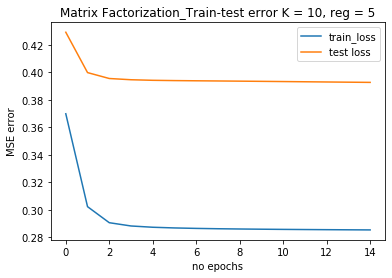

In [12]:
# for every user I want to have all the songs and all the ratings so I don't to loop over them again
# run this for 15 epochs and use regularization penalty
# we built Wi for each user i based on all songs he rated (sid, r )
# r is lenth T
# W[i] --> K
# c[sid] --> T
# mu scalar
# U[sid] --> TxK
# bi --> T (bi is scaler so I want to sum up over the T values)
# we need r to be numay array in order to be able to do subsdtraction
epochs = 15
reg = 5
train_losses = []
test_losses = []
time_epoch = []
for epoch in range(epochs):
    print("epoch:", epoch)
    epoch_start = datetime.datetime.now()
    t0 = datetime.datetime.now()
    for i in user_songs_train.keys():
        sid, r = user_songs_r[i]
        wi1 = U[sid].T.dot(U[sid]) + np.eye(K)*reg
        wi2 = (r - b[i]-c[sid]-mu).dot(U[sid])
        bi = (r-U[sid].dot(W[i]) - c[sid]-mu).sum()
        # set the updates
        W[i] = np.linalg.solve(wi1, wi2)
        b[i] = bi/(len(user_songs_train)+reg)
        
        if i%(N/10) ==0:
            print("i:", i, "N:", N)
    print("updated W and b:", datetime.datetime.now()-t0)
    # update U and c
    t0 = datetime.datetime.now()
    for j in song_users_train.keys():
        try:
            uid, r = song_users_r[j]
            ui1 = W[uid].T.dot(W[uid]) + np.eye(K)*reg
            ui2 = (r - b[uid]-c[j]-mu).dot(W[uid])
            cj = (r-W[uid].dot(U[j]) - b[uid]-mu).sum()
            # set the updates
            U[j] = np.linalg.solve(ui1, ui2)
            c[j] = bi/(len(song_users_train)+reg)
            if i%(M/10) ==0:
                print("i:", i, "M:", M)
        except KeyError:
        # possible not to have any rating for a movie
            pass
    print("updated U and c:", datetime.datetime.now()-t0)
    epoch_end = datetime.datetime.now()
    delta = (epoch_end-epoch_start).total_seconds()
    time_epoch.append(delta)
    print("epoch duration:", epoch_end-epoch_start)
     
    # store train loss
    t0 = datetime.datetime.now()
    train_losses.append(get_loss(song_users_r))
    # store test loss:
    test_losses.append(get_loss(song_users_r_test))
    print("calculate cost:", datetime.datetime.now()-t0)
    print("train loss", train_losses[-1])
    print("test loss", test_losses[-1])
print("train losses:", train_losses)
print("test losses:", test_losses)
print("average computational time per epoch:", mean(time_epoch))

# plt losses
plt.plot(train_losses, label = "train_loss")
plt.plot(test_losses, label = "test loss")
plt.xlabel('no epochs')
plt.ylabel('MSE error')
plt.title('Matrix Factorization_Train-test error K = 10, reg = 5')
plt.legend()
plt.show()

In [13]:
mean(time_epoch)

0.3241845333333333